In [1]:
from typing import Any, Final, Literal
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

device: Final[torch.device] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [154]:
class Linear:

    def __init__(self, fan_in: int, fan_out: int, g: torch.Generator,
        bias: bool = True) -> None:
        # self.weight = (torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)).to(device)
        self.weight = (torch.randn((fan_in, fan_out), generator=g)).to(device)

        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5,
                 momentum: float = 0.1) -> None:
        # Hyperparameters
        self.eps: float = eps
        self.momentum: float = momentum
        self.training: bool = True

        # Parameters (trainable):
        # gamma and beta are like the weight and bias in a linear layer
        # gamma: scale parameter
        self.gamma = torch.ones(dim).to(device)
        # beta: shift parameter
        self.beta = torch.zeros(dim).to(device)

        # Buffers (trained with momentum):
        # Start from normal distribution.
        self.running_mean: torch.Tensor = torch.zeros(dim).to(device)
        self.running_var: torch.Tensor = torch.ones(dim).to(device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True,
                                               unbiased=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_norm: Final = (x - x_mean) / torch.sqrt(x_var + self.eps)
        x_norm_scaled: Final[torch.Tensor] = self.gamma * x_norm + self.beta

        # Update running mean and variance
        if (self.training):
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        self.out: torch.Tensor = x_norm_scaled
        return x_norm_scaled

    @property
    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out: torch.Tensor = torch.tanh(x)
        return self.out

    @property
    def parameters(self) -> list[torch.Tensor]:
        return []


In [81]:
words: Final[list[str]] = open("names.txt", 'r').read().splitlines()
chars: Final[list[str]] = sorted(list(set(''.join(words))))
stoi: Final[dict[str, int]] = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos: Final[dict[int, str]] = {i: char for char, i in stoi.items()}
char_cnt: Final[int] = len(stoi)

In [82]:
def create_dataset(words: list[str], block_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    X: list[list[int]] = []
    Y: list[int] = []
    for word in words:
        context: list[int] = [0] * block_size
        for ix in word + '.':
            X.append(context)
            Y.append(stoi[ix])
            context = context[1:] + [stoi[ix]]
    X_t = torch.tensor(X)
    Y_t = torch.tensor(Y)
    print(X_t.shape, Y_t.shape)
    return torch.tensor(X), torch.tensor(Y)

In [83]:
import random
random.seed(42)
random.shuffle(words)

block_size: Final[int] = 3 # context length
train_set_ratio: float = 0.8
valid_set_ratio: float = 0.1
test_set_ratio: float = 0.1

n1: int = int(len(words) * train_set_ratio)
n2: int = int(len(words) * (train_set_ratio + valid_set_ratio))

X_train, Y_train = create_dataset(words[:n1], block_size)
X_val, Y_val = create_dataset(words[n1:n2], block_size)
X_test, Y_test = create_dataset(words[n2:], block_size)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [84]:
# ==================== Model ====================
n_embd: Final[int] = 10
n_hidden: Final[int] = 100
g: torch.Generator = torch.Generator().manual_seed(2147483647)

vocab_size: Final[int] = char_cnt
C: torch.Tensor = torch.randn((vocab_size, n_embd), generator=g).to(device)
layers: Final[list[Any]] = [
    Linear(n_embd * block_size, n_hidden, g),   Tanh(),
    Linear(n_hidden, n_hidden, g),              Tanh(),
    Linear(n_hidden, n_hidden, g),              Tanh(),
    Linear(n_hidden, n_hidden, g),              Tanh(),
    Linear(n_hidden, n_hidden, g),              Tanh(),
    Linear(n_hidden, vocab_size, g)
]

with torch.no_grad():
    # Last linear layer: make it less confident
    layers[-1].weight *= 0.1
    # Apply tanh gain to the linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # tanh is a squashing function, use the gain to offset it.
            layer.weight *= (5 / 3)

parameters: Final[list[torch.Tensor]] = [C] + [
    param for layer in layers for param in layer.parameters
]
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# ==================== Training ====================

epochs: Final[int] = 200000
loss: Final[torch.Tensor] = torch.tensor(1000.0)
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi: list[int] = []
p_update_i: Final[list[list[float]]] = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    embcat = emb.view(-1, n_embd * block_size)
    in_n_out = embcat
    for layer in layers:
        in_n_out = layer(in_n_out)
    loss = F.cross_entropy(in_n_out, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = (0.1 if epoch < 25000 else
        0.05 if epoch < 100000 else
        0.01 if epoch < 150000 else
        0.005 if epoch < 180000 else
        0.001)
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())
    with torch.no_grad():
        p_update_ratio: list[float] = []
        for p in parameters:
            assert p.grad is not None
            p_update_ratio.append((lr * p.grad.std() / p.data.std()).log10().item())
        p_update_i.append(p_update_ratio)

    if epoch >= 1000:
        break


Number of parameters: 46497
Epoch: 0 / 200000, Loss: 3.2995779514312744
Epoch: 1000 / 200000, Loss: 2.3944091796875


In [97]:

def visualize_tanh_layer(mode: Literal["out", "gradient"]) -> None:
    plt.figure(figsize=(20, 4))
    legends: list[str] = []
    for i, layer in enumerate(layers[:-1]): # exclude the last layer
        if not isinstance(layer, Tanh):
            continue
        if mode == "out":
            t = layer.out
        elif mode == "gradient":
            t = layer.out.grad
        else:
            raise ValueError(f"Unknown mode: {mode}")
        assert t is not None
        t = t.to("cpu")
        print(f"layer {i} {layer.__class__.__name__:10s} "
              f"mean: {t.mean():+.7f}, std: {t.std():.7f} "
              f"saturated: {(t.abs() > 0.97).float().mean() * 100:.7f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[1:].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
    plt.legend(legends)
    plt.title("Tanh activation distribution")

def visualize_linear_layer(mode: Literal["out", "gradient"]) -> None:
    plt.figure(figsize=(20, 4))
    legends: list[str] = []
    for i, layer in enumerate(layers[:-1]): # exclude the last layer
        if not isinstance(layer, Linear):
            continue
        if mode == "out":
            t = layer.out
        elif mode == "gradient":
            t = layer.out.grad
        else:
            raise ValueError(f"Unknown mode: {mode}")
        assert t is not None
        t = t.to("cpu")
        print(f"layer {i} {layer.__class__.__name__:10s} "
              f"mean: {t.mean():+.7f}, std: {t.std():.7f} "
              f"saturated: {(t.abs() > 0.97).float().mean() * 100:.7f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[1:].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
    plt.legend(legends)
    plt.title("Linear layer output distribution")

def visualize_parameters() -> None:
    plt.figure(figsize=(20, 4))
    legends: list[str] = []
    for i, p in enumerate(parameters):
        if p.ndim != 2:
            continue
        assert p.grad is not None
        t = p.grad.to("cpu")
        print(f"weight {i} {str(tuple(p.shape)):10s} | "
              f"grad mean: {t.mean():+f} | "
              f"grad std: {t.std():e} | "
              f"grad/p_val ratio: {t.std() / p.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[1:].detach(), hy.detach())
        legends.append(f"weight {i} {tuple(p.shape)}")
    plt.legend(legends)
    plt.title("Weight gradient distribution")


layer 1 Tanh       mean: -0.0343506, std: 0.7659938 saturated: 22.8593750%
layer 3 Tanh       mean: -0.0067960, std: 0.7104620 saturated: 11.4375000%
layer 5 Tanh       mean: -0.0047465, std: 0.7151223 saturated: 10.6640625%
layer 7 Tanh       mean: -0.0177831, std: 0.7045705 saturated: 9.6171875%
layer 9 Tanh       mean: -0.0106310, std: 0.7124717 saturated: 9.6796875%


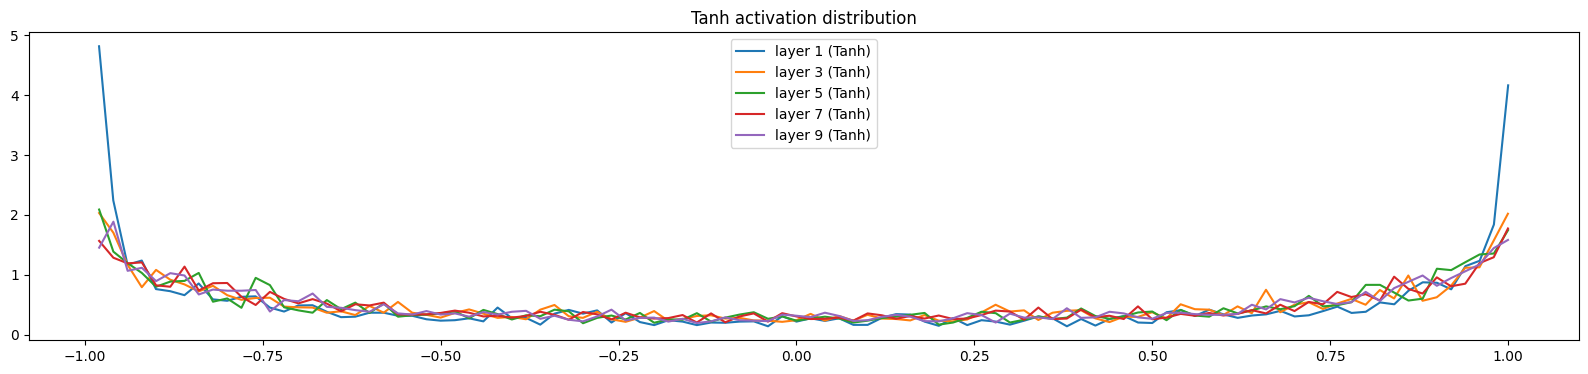

In [86]:
visualize_tanh_layer("out")

layer 1 Tanh       mean: +0.0000088, std: 0.0010224 saturated: 0.0000000%
layer 3 Tanh       mean: +0.0000066, std: 0.0009957 saturated: 0.0000000%
layer 5 Tanh       mean: -0.0000120, std: 0.0009442 saturated: 0.0000000%
layer 7 Tanh       mean: -0.0000028, std: 0.0008143 saturated: 0.0000000%
layer 9 Tanh       mean: +0.0000011, std: 0.0006271 saturated: 0.0000000%


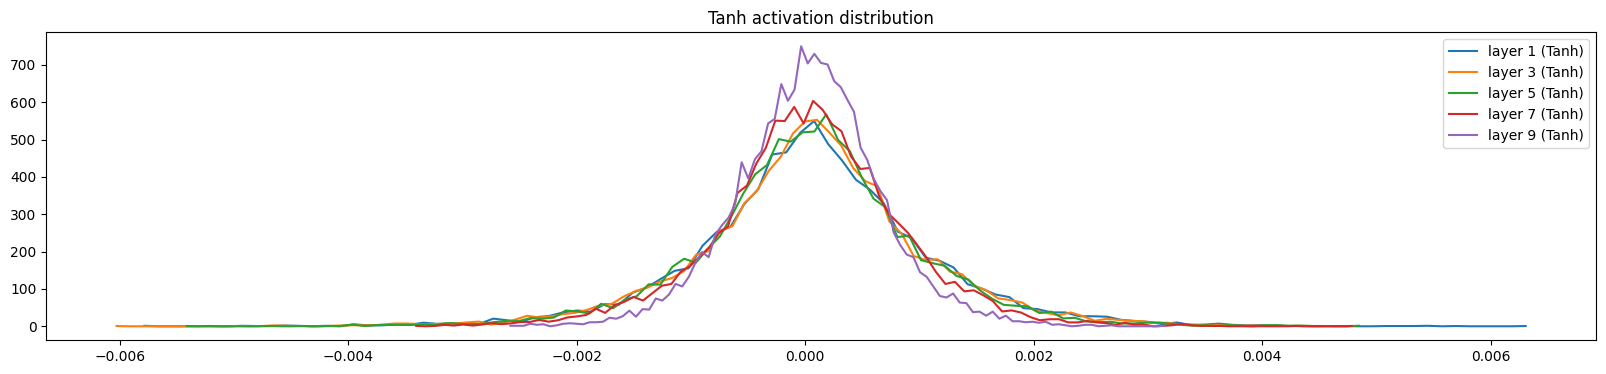

In [87]:
visualize_tanh_layer("gradient")

layer 0 Linear     mean: -0.0813609, std: 1.7380900 saturated: 57.5937500%
layer 2 Linear     mean: -0.0180301, std: 1.3182635 saturated: 47.7500000%
layer 4 Linear     mean: -0.0086120, std: 1.3333018 saturated: 49.3281250%
layer 6 Linear     mean: -0.0202053, std: 1.2701252 saturated: 47.1328125%
layer 8 Linear     mean: -0.0212759, std: 1.2683359 saturated: 48.2421875%


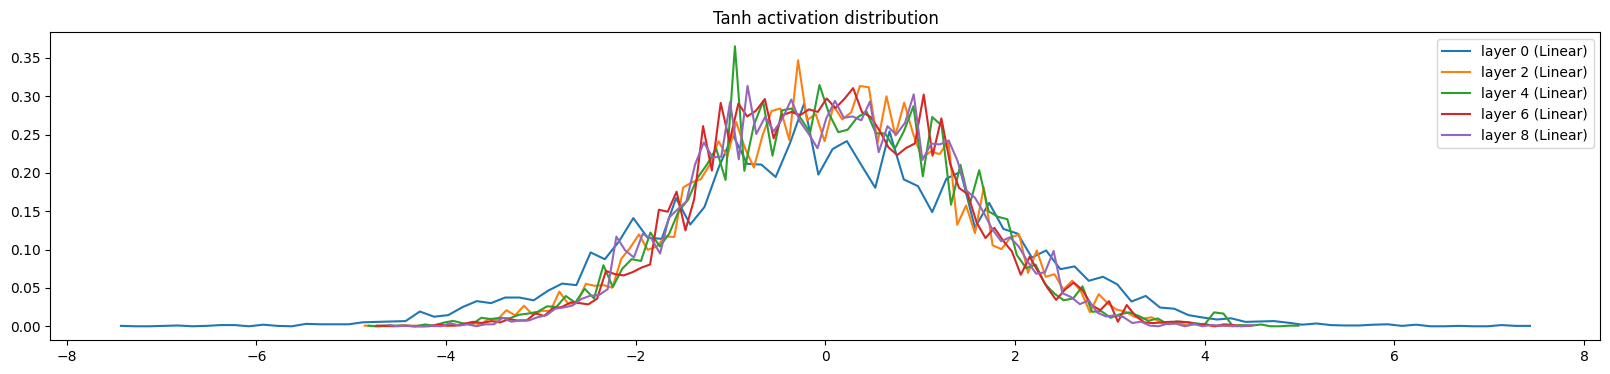

In [88]:
visualize_linear_layer("out")

layer 0 Linear     mean: +0.0000035, std: 0.0005474 saturated: 0.0000000%
layer 2 Linear     mean: +0.0000050, std: 0.0006011 saturated: 0.0000000%
layer 4 Linear     mean: -0.0000123, std: 0.0005541 saturated: 0.0000000%
layer 6 Linear     mean: -0.0000019, std: 0.0004925 saturated: 0.0000000%
layer 8 Linear     mean: -0.0000020, std: 0.0003756 saturated: 0.0000000%


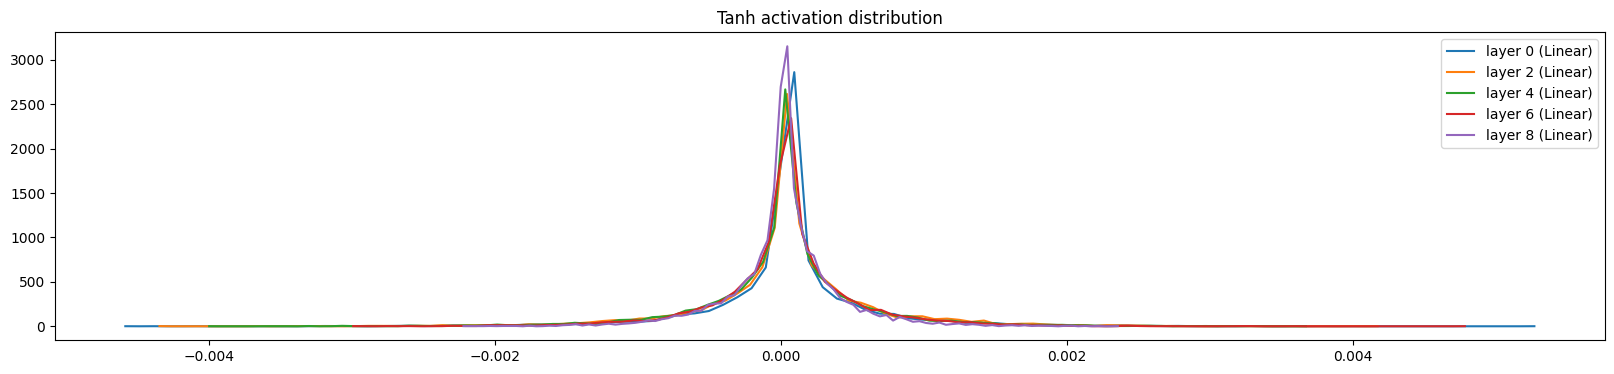

In [89]:
visualize_linear_layer("gradient")

weight 0 (27, 10)   | grad mean: +0.000566 | grad std: 6.722958e-03 | grad/p_val ratio: 6.724065e-03
weight 1 (30, 100)  | grad mean: +0.000022 | grad std: 6.774731e-03 | grad/p_val ratio: 2.171716e-02
weight 3 (100, 100) | grad mean: -0.000019 | grad std: 5.547162e-03 | grad/p_val ratio: 3.317737e-02
weight 5 (100, 100) | grad mean: +0.000050 | grad std: 4.539709e-03 | grad/p_val ratio: 2.683712e-02
weight 7 (100, 100) | grad mean: +0.000034 | grad std: 3.873016e-03 | grad/p_val ratio: 2.297010e-02
weight 9 (100, 100) | grad mean: +0.000048 | grad std: 2.889639e-03 | grad/p_val ratio: 1.708120e-02
weight 11 (100, 27)  | grad mean: -0.000000 | grad std: 1.084467e-02 | grad/p_val ratio: 1.494217e-01


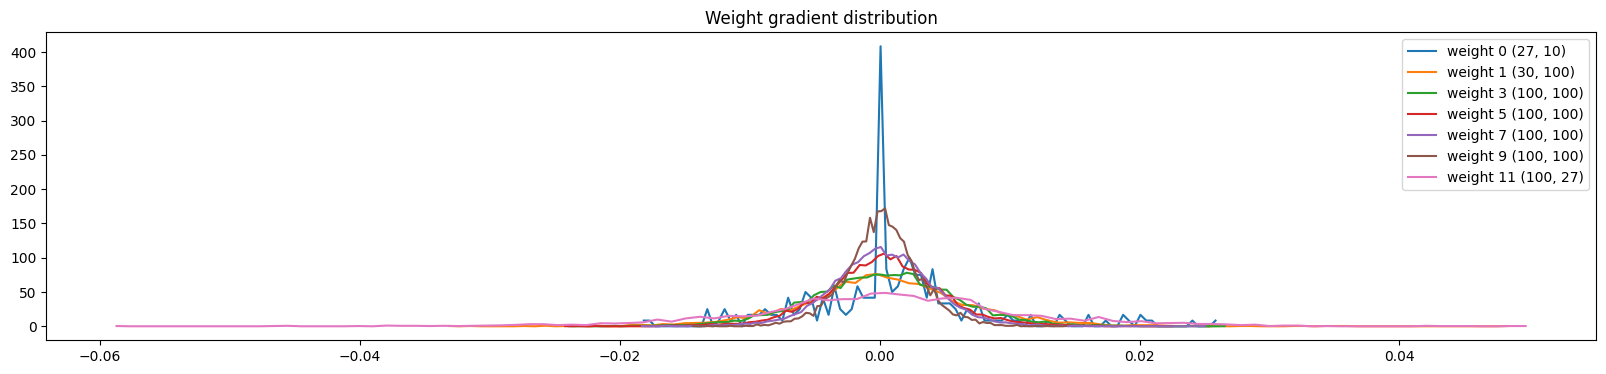

In [90]:
visualize_parameters()

In [91]:
def visualize_parameter_update_ratio() -> None:
    plt.figure(figsize=(20, 4))
    legends: Final[list[str]] = []
    for p_idx, p in enumerate(parameters):
        if p.ndim != 2:
            continue
        plt.plot([p_update_i[step][p_idx] for step in range(len(p_update_i))])
        legends.append(f"weight {p_idx} {tuple(p.shape)}")
    # These ratios should be ~1e-3, indicated by the `[-3, -3], 'k'`.
    plt.plot([0, len(p_update_i)], [-3, -3], 'k')
    plt.legend(legends)
    plt.title("Weight gradient update ratio")


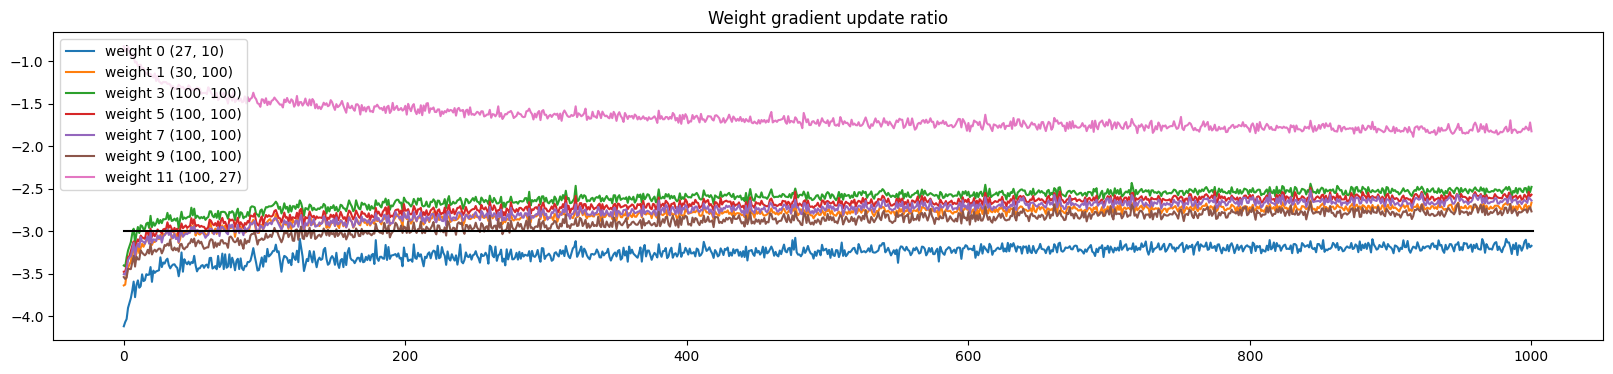

In [92]:
visualize_parameter_update_ratio()

In [163]:
# Now uses batch normalization

# ==================== Model ====================
n_embd: Final[int] = 10
n_hidden: Final[int] = 100
g: torch.Generator = torch.Generator().manual_seed(2147483647)

vocab_size: Final[int] = char_cnt
C: torch.Tensor = torch.randn((vocab_size, n_embd), generator=g).to(device)
layers: Final[list[Any]] = [
    Linear(n_embd * block_size, n_hidden, g),   BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,            n_hidden, g),   BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,            n_hidden, g),   BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,            n_hidden, g),   BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,            n_hidden, g),   BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,            vocab_size, g), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # Last linear layer: make it less confident
    layers[-1].gamma *= 0.1
    # Apply tanh gain to the linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # tanh is a squashing function, use the gain to offset it.
            layer.weight *= 1.0 # (5 / 3)

parameters: Final[list[torch.Tensor]] = [C] + [
    param for layer in layers for param in layer.parameters
]
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# ==================== Training ====================

epochs: Final[int] = 200000
loss: Final[torch.Tensor] = torch.tensor(1000.0)
mini_batch_size: Final[int] = 128

lossi: list[float] = []
stepi: list[int] = []
p_update_i: Final[list[list[float]]] = []

for epoch in range(epochs):
    # Mini-batch
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))
    X_t_mini = X_train[ix]
    Y_t_mini = Y_train[ix]

    # Forward pass
    emb = C[X_t_mini]
    embcat = emb.view(-1, n_embd * block_size)
    in_n_out = embcat
    for layer in layers:
        in_n_out = layer(in_n_out)
    loss = F.cross_entropy(in_n_out, Y_t_mini)
    if (epoch % 1000) == 0:
        print(f"Epoch: {epoch} / {epochs}, Loss: {loss.item()}")

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = (1 if epoch < 25000 else
        0.05 if epoch < 100000 else
        0.01 if epoch < 150000 else
        0.005 if epoch < 180000 else
        0.001)
    for p in parameters:
        assert p.grad is not None
        p.data -= lr * p.grad

    stepi.append(epoch)
    lossi.append(loss.log10().item())
    with torch.no_grad():
        p_update_ratio: list[float] = []
        for p in parameters:
            assert p.grad is not None
            p_update_ratio.append((lr * p.grad.std() / p.data.std()).log10().item())
        p_update_i.append(p_update_ratio)

    if epoch >= 1000:
        break


Number of parameters: 47551
Epoch: 0 / 200000, Loss: 3.303133487701416
Epoch: 1000 / 200000, Loss: 2.1820218563079834


layer 2 Tanh       mean: +0.0192563, std: 0.6301582 saturated: 3.3203125%
layer 5 Tanh       mean: -0.0083323, std: 0.6360486 saturated: 3.3593752%
layer 8 Tanh       mean: -0.0304412, std: 0.6406463 saturated: 3.5937500%
layer 11 Tanh       mean: -0.0299072, std: 0.6348348 saturated: 3.5546877%
layer 14 Tanh       mean: +0.0101906, std: 0.6394935 saturated: 3.7031248%


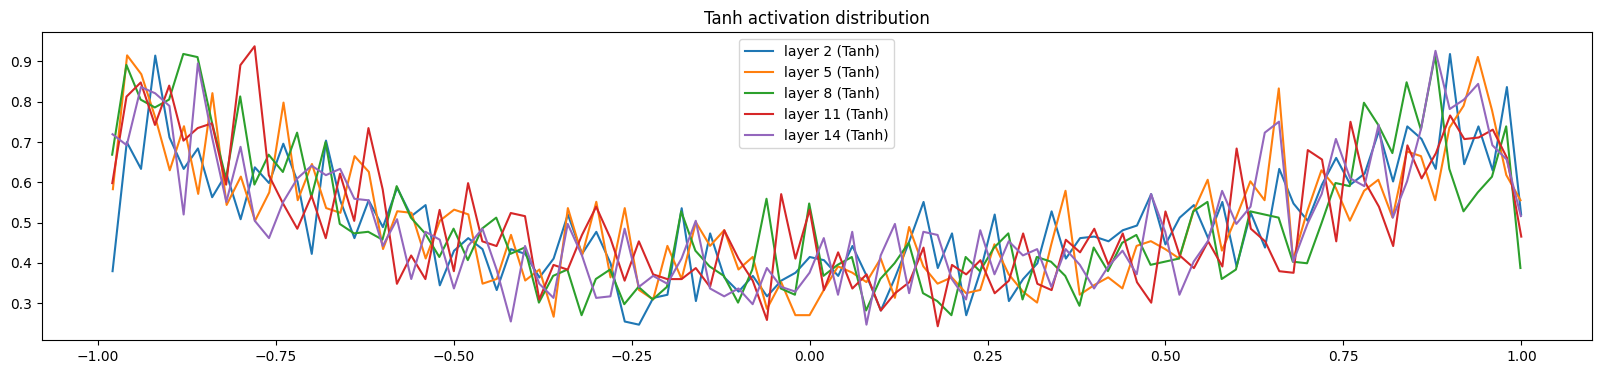

In [164]:
visualize_tanh_layer("out")

layer 2 Tanh       mean: +0.0000000, std: 0.0015307 saturated: 0.0000000%
layer 5 Tanh       mean: +0.0000000, std: 0.0013432 saturated: 0.0000000%
layer 8 Tanh       mean: +0.0000000, std: 0.0012530 saturated: 0.0000000%
layer 11 Tanh       mean: +0.0000000, std: 0.0011616 saturated: 0.0000000%
layer 14 Tanh       mean: -0.0000000, std: 0.0011638 saturated: 0.0000000%


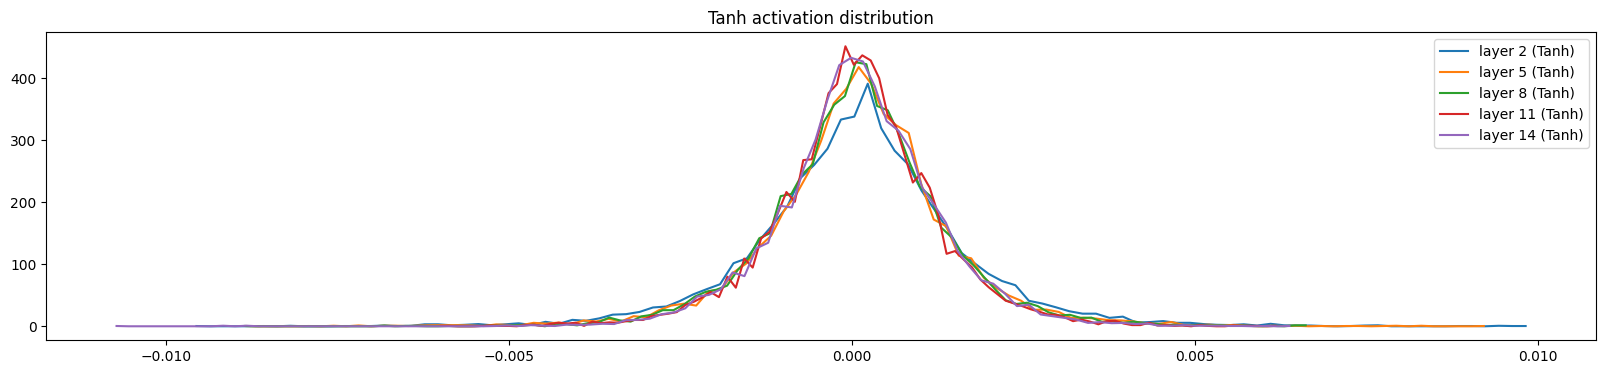

In [165]:
visualize_tanh_layer("gradient")

layer 0 Linear     mean: -0.3646128, std: 6.5716972 saturated: 88.3828125%
layer 3 Linear     mean: +0.0674016, std: 6.2599769 saturated: 87.3593750%
layer 6 Linear     mean: +0.0283778, std: 6.7302532 saturated: 88.7890625%
layer 9 Linear     mean: -0.1727966, std: 6.5170255 saturated: 88.8125000%
layer 12 Linear     mean: +0.1851019, std: 6.5659885 saturated: 88.4062500%
layer 15 Linear     mean: +0.7256302, std: 7.3055558 saturated: 90.2777786%


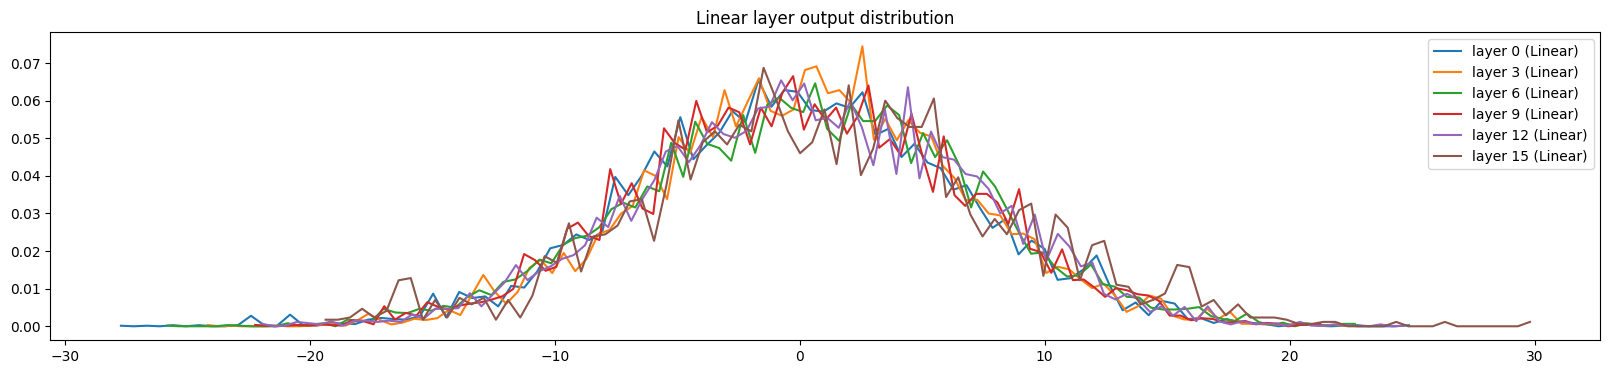

In [166]:
visualize_linear_layer("out")

layer 0 Linear     mean: -0.0000000, std: 0.0001800 saturated: 0.0000000%
layer 3 Linear     mean: +0.0000000, std: 0.0001560 saturated: 0.0000000%
layer 6 Linear     mean: -0.0000000, std: 0.0001381 saturated: 0.0000000%
layer 9 Linear     mean: +0.0000000, std: 0.0001265 saturated: 0.0000000%
layer 12 Linear     mean: +0.0000000, std: 0.0001200 saturated: 0.0000000%
layer 15 Linear     mean: +0.0000000, std: 0.0002215 saturated: 0.0000000%


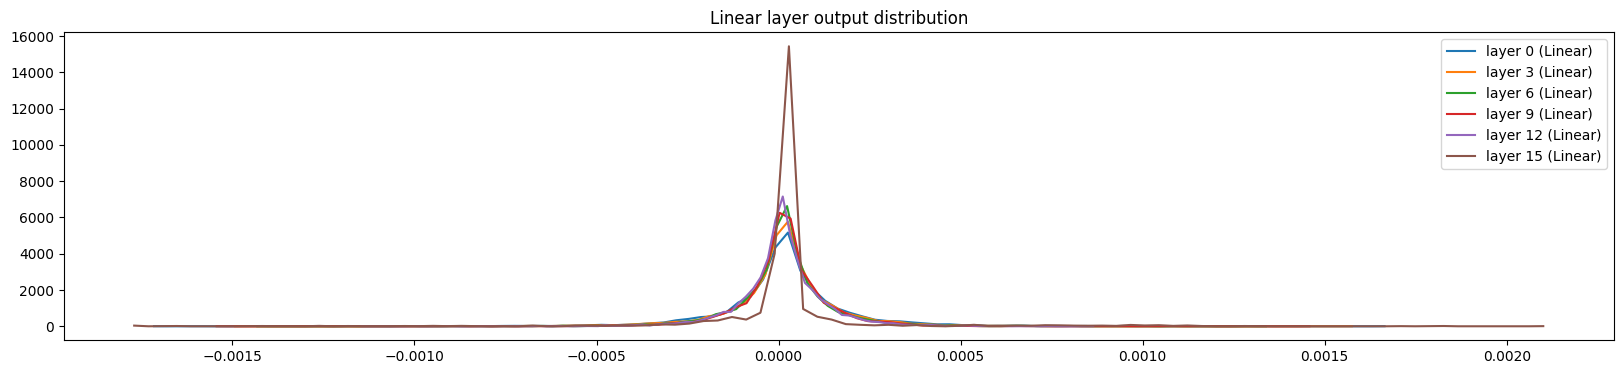

In [167]:
visualize_linear_layer("gradient")

weight 0 (27, 10)   | grad mean: +0.000000 | grad std: 7.034399e-03 | grad/p_val ratio: 6.933850e-03
weight 1 (30, 100)  | grad mean: -0.000013 | grad std: 2.521517e-03 | grad/p_val ratio: 2.457015e-03
weight 5 (100, 100) | grad mean: -0.000005 | grad std: 1.155742e-03 | grad/p_val ratio: 1.159088e-03
weight 9 (100, 100) | grad mean: -0.000016 | grad std: 1.068041e-03 | grad/p_val ratio: 1.059976e-03
weight 13 (100, 100) | grad mean: +0.000006 | grad std: 1.059274e-03 | grad/p_val ratio: 1.055717e-03
weight 17 (100, 100) | grad mean: -0.000001 | grad std: 9.984131e-04 | grad/p_val ratio: 9.941465e-04
weight 21 (100, 27)  | grad mean: +0.000030 | grad std: 1.785384e-03 | grad/p_val ratio: 1.804393e-03


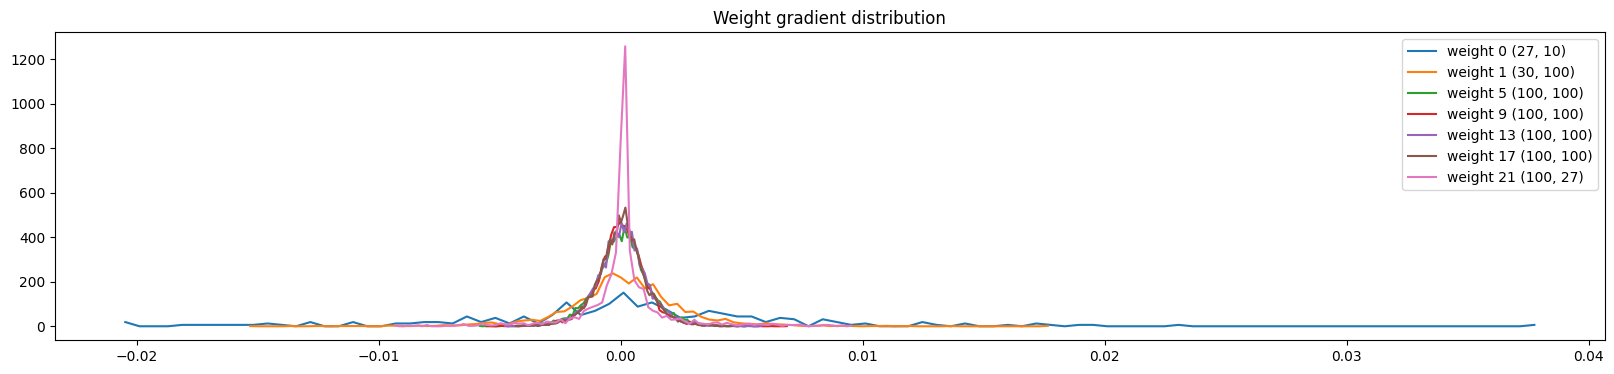

In [168]:
visualize_parameters()

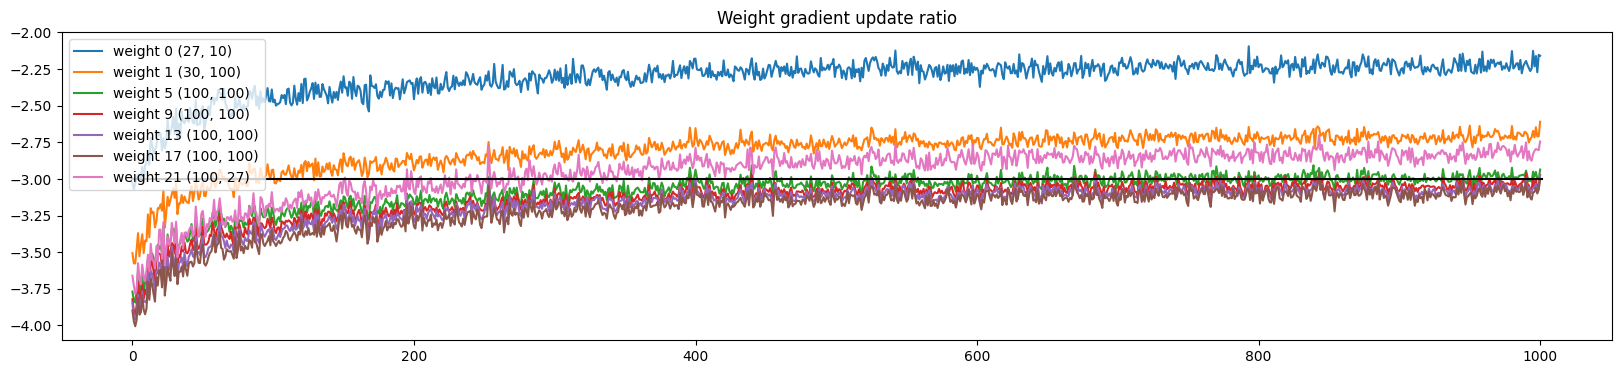

In [169]:
visualize_parameter_update_ratio()